In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import scipy.stats as scs
from scipy import spatial
import sklearn
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
import seaborn as sns

**Import Files**

In [357]:
missing_values = ["n/a", "na", "--", "NA", "null"]

In [ ]:
df_SyncPatient = pd.read_csv('datasetPracticeFusionDiabetes/training_SyncPatient.csv', 
                             skipinitialspace=True, na_values = missing_values)
#df_SyncPatient.head(5)

In [359]:
#os.chdir('datasetPracticeFusionDiabetes/')
diagnosisT = pd.read_csv('training_SyncDiagnosis.csv')
allergyT = pd.read_csv('training_SyncAllergy.csv')
immunT = pd.read_csv('training_SyncImmunization.csv')
labObsT = pd.read_csv('training_SyncLabObservation.csv')
labPanT = pd.read_csv('training_SyncLabPanel.csv')
labResT = pd.read_csv('training_SyncLabResult.csv')
medicationT = pd.read_csv('training_SyncMedication.csv')
patientT = pd.read_csv('training_SyncPatient.csv')
patientCondT = pd.read_csv('training_SyncPatientCondition.csv')
smokingT = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescripT = pd.read_csv('training_SyncPrescription.csv')
trnscrpT = pd.read_csv('training_SyncTranscript.csv')
trnscrpAT = pd.read_csv('training_SyncTranscriptAllergy.csv')
trnscrpDT = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
trnscrptMT = pd.read_csv('training_SyncTranscriptMedication.csv')
#myfileT = pd.read_csv('myfile.csv', header=None)
conditionT = pd.read_csv('SyncCondition.csv')
smokingT = pd.read_csv('SyncSmokingStatus.csv')

In [360]:
def makeBP():
    bloodpressure1 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].mean()
    bloodpressure2 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].max()
    bloodpressure3 = trnscrpT.groupby(['PatientGuid'])[['SystolicBP', 'DiastolicBP']].min()
    bloodpressure = pd.concat([bloodpressure1, bloodpressure2, bloodpressure3], axis = 1)
    bloodpressure.columns = ['meanSystolicBP', 'meanDiastolicBP', 'maxSystolicBP', 'maxDiastolicBP', 'minSystolicBP', 'minDiastolicBP']
    bloodpressure['SystDiff'] = np.abs(bloodpressure['maxSystolicBP'] - bloodpressure['minSystolicBP'])
    bloodpressure['DiastDiff'] = np.abs(bloodpressure['maxDiastolicBP'] - bloodpressure['minDiastolicBP'])
    bloodpressure['isElevated'] = 0
    bloodpressure['isStage1HBP'] = 0
    bloodpressure['isStage2HBP'] = 0
    bloodpressure['isHBPCrisis'] = 0
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 120) & (bloodpressure['meanSystolicBP'] < 130)) & (bloodpressure['meanDiastolicBP'] < 80), 'isElevated'] = 1
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 130) & (bloodpressure['meanSystolicBP'] < 140)) | ((bloodpressure['meanDiastolicBP'] >= 80) & (bloodpressure['meanDiastolicBP'] < 90)), 'isStage1HBP'] = 1
    bloodpressure.loc[((bloodpressure['meanSystolicBP'] >= 140) & (bloodpressure['meanSystolicBP'] < 180)) | ((bloodpressure['meanDiastolicBP'] >= 90) & (bloodpressure['meanDiastolicBP'] < 120)), 'isStage2HBP'] = 1
    bloodpressure.loc[(bloodpressure['meanSystolicBP'] >= 180) | (bloodpressure['meanDiastolicBP'] >= 120), 'isHBPCrisis'] = 1
    bloodpressure.loc[bloodpressure['isHBPCrisis'] == 1, 'isStage2HBP'] = 0
    bloodpressure.loc[bloodpressure['isStage2HBP'] == 1, 'isStage1HBP'] = 0
    bloodpressure.loc[bloodpressure['isStage1HBP'] == 1, 'isElevated'] = 0
    bloodpressure = bloodpressure.reset_index()
    return bloodpressure

In [361]:
def makeBMI():
    trnscrpT['BMI'] = trnscrpT['BMI'].replace(0.000, np.nan)
    bmi1 = trnscrpT.groupby(['PatientGuid'])['BMI'].mean()
    bmi2 = trnscrpT.groupby(['PatientGuid'])['BMI'].max()
    bmi3 = trnscrpT.groupby(['PatientGuid'])['BMI'].min()
    bmi = pd.concat([bmi1, bmi2, bmi3], axis = 1)
    bmi.columns = ['MeanBMI', 'MaxBMI', 'MinBMI']
    bmi['isOverweight'] = 0
    bmi['isObese'] = 0
    bmi.loc[(bmi['MeanBMI'] >= 25) & (bmi['MeanBMI'] < 30), 'isOverweight'] = 1
    bmi.loc[bmi['MeanBMI'] >= 30, 'isObese'] = 1
    bmi.loc[bmi['MeanBMI'] < 19, 'isUnderWeight'] = 1
    bmi['BMIDiff'] = np.abs(bmi['MaxBMI'] - bmi['MinBMI'])
    bmi = bmi.reset_index()
    return bmi

In [362]:
def makeConditions():
    diaganalysis = pd.merge(patientT, diagnosisT, on=['PatientGuid'])
    chidata = diaganalysis[['PatientGuid', 'DMIndicator', 'ICD9Code']].drop_duplicates()
    chidata.index = chidata['PatientGuid']
    dummies = pd.get_dummies(chidata['ICD9Code']).reset_index()
    dummies = dummies.groupby(['PatientGuid'])[dummies.columns[1:]].sum()
    # dummies = dummies.replace(2, 1)
    chidata = chidata[['PatientGuid', 'DMIndicator']]
    chidata = chidata.drop_duplicates()
    chidata = pd.concat([chidata, dummies], axis=1)
    chidata['DMIndicator'] = chidata['DMIndicator'].astype(float)
    return chidata

In [363]:
def heartDisease(text):
    if bool(re.match('41[0-4]|42[0-5]|427|429|74[5-6]', text)) == True:
        return 1
    return 0
def CAD(text):
    if bool(re.match('41[0-4]|429', text)) == True:
        return 1
    return 0
def cardiomyopathy(text):
    if bool(re.match('42[0-5]', text)) == True:
        return 1
    return 0
def CHF(text):
    if bool(re.match('426', text)) == True:
        return 1
    return 0
def arrhythmias(text):
    if bool(re.match('427', text)) == True:
        return 1
    return 0
def heartdefects(text):
    if bool(re.match('74[5-6]', text)) == True:
        return 1
    return 0
def stroke(text):
    if bool(re.match('43[0-1]|43[3-6]|997.02', text)) == True:
        return 1
    return 0
def sleepApnea(text):
    if bool(re.match('727.23|780.57', text)) == True:
        return 1
    return 0
def gestDiab(text):
    if bool(re.match('648.8', text)) == True:
        return 1
    return 0
def polyOvary(text):
    if bool(re.match('256.4', text)) == True:
        return 1
    return 0
def frozenShoulder(text):
    if bool(re.match('726.0', text)) == True:
        return 1
    return 0
def hemochr(text):
    if bool(re.match('275.03', text)) == True:
        return 1
    return 0
def hepatitis(text):
    if bool(re.match('070.2|070.3', text)) == True:
        return 1
    return 0
def diabCompl(text):
    if bool(re.match('250.[1-3]|250.5|250.8|251.[0-2]|270.3|775.6|962.3', text)) == True:
        return 1
    return 0
def kidneyFailure(text):
    if bool(re.match('58[4-5]', text)) == True:
        return 1
    return 0
def dementia(text):
    if bool(re.match('331|290|294|797', text)) == True:
        return 1
    return 0
def acanthosis(text):
    if bool(re.match('701.2', text)) == True:
        return 1
    return 0
def blindness(text):
    if bool(re.match('369', text)) == True:
        return 1
    return 0
def sDysfunction(text):
    if bool(re.match('302.7', text)) == True:
        return 1
    return 0
def preDiabetes(text):
    if bool(re.match('790.29', text)) == True:
        return 1
    return 0

In [364]:
# remove the fractional part (remove Period)
def stripPeriods(text):
    result = re.sub('\.', "", text)
    return result

In [365]:
def makeSpecials():
    data = diagnosisT.copy()
    data['ICD9'] = data['ICD9Code'].apply(stripPeriods)
    data['hasHeartDisease'] = data['ICD9Code'].apply(heartDisease)
    data['hasCAD'] = data['ICD9Code'].apply(CAD)
    data['hasCardiomyo'] = data['ICD9Code'].apply(cardiomyopathy)
    data['hasArrhy'] = data['ICD9Code'].apply(arrhythmias)
    data['hasHeartDefects'] = data['ICD9Code'].apply(heartdefects)
    data['hasCHF'] = data['ICD9Code'].apply(CHF)
    data['hasStroke'] = data['ICD9Code'].apply(stroke)
    data['hasSleepA'] = data['ICD9Code'].apply(sleepApnea)
    data['hasGestDiab'] = data['ICD9Code'].apply(gestDiab)
    data['hasPolyO'] = data['ICD9Code'].apply(polyOvary)
    data['hasFrozenShoulder'] = data['ICD9Code'].apply(frozenShoulder)
    data['hasHemoChr'] = data['ICD9Code'].apply(hemochr)
    data['hasHepatitis'] = data['ICD9Code'].apply(hepatitis)
    data['hasDiabComp'] = data['ICD9Code'].apply(diabCompl)
    data['hasKidneyF'] = data['ICD9Code'].apply(kidneyFailure)
    data['hasDementia'] = data['ICD9Code'].apply(dementia)
    data['hasAcanthosis'] = data['ICD9Code'].apply(acanthosis)
    data['hasBlindness'] = data['ICD9Code'].apply(blindness)
    data['hasSDysf'] = data['ICD9Code'].apply(sDysfunction)
    data['hasPreDiab'] = data['ICD9Code'].apply(preDiabetes)
    diagnosisSummary = data.groupby(['PatientGuid'])[['hasHeartDisease', 'hasCHF', 'hasStroke', 'hasSleepA', 'hasGestDiab','hasPolyO', 'hasFrozenShoulder', 'hasHemoChr','hasHepatitis', 'hasDiabComp', 'hasKidneyF', 'hasDementia','hasAcanthosis', 'hasBlindness' ,'hasSDysf', 'hasPreDiab']].max()
    diagnosisSummary = diagnosisSummary.reset_index()
    return diagnosisSummary

In [366]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
"""
        '140-239': 'neoplasms',
        '240-279': 'endocrine, nutritional and metabolic, immunity disorders',
        '280-289': 'diseases of the blood and blood-forming organs',
        '290-319': 'mental disorders',
        '320-359': 'nervous system',
        '360-389': 'sense organs',
        '390-459': 'circulatory system',
        '460-519': 'respiratory system',
        '520-579': 'digestive system',
        '580-629': 'genitourinary system',
        '630-679': 'complications of pregnancy, childbirth, and the puerperium',
        '680-709': 'skin and subcutaneous tissue',
        '710-739': 'musculoskeletal system and connective tissue',
        '740-759': 'congenital anomalies',
        '760-779': 'certain conditions originating in the perinatal period',
        '780-799': 'symptoms, signs, and ill-defined conditions',
        '800-999': 'injury and poisoning',
        'E-V': 'external causes of injury and supplemental classification'
"""
            
def ICD9Label(text):
    if bool(re.match('14[0-9]|2[0-3][0-9]', text)) == True:
        return 'neoplasms'
    elif bool(re.match('2[4-7][0-9]', text)) == True:
        return 'endoctrine'
    elif bool(re.match('28[0-9]', text)) == True:
        return 'blood'
    elif bool(re.match('29[0-9]|3[0-1][0-9]', text)) == True:
        return 'mental'
    elif bool(re.match('3[2-5][0-9]', text)) == True:
        return 'nervous'
    elif bool(re.match('3[6-8][0-9]', text)) == True:
        return 'sense'
    elif bool(re.match('39[0-9]|4[0-5][0-9]', text)) == True:
        return 'circulatory'
    elif bool(re.match('4[6-9][0-9]|5[0-1][0-9]', text)) == True:
        return 'respiratory'
    elif bool(re.match('5[2-7][0-9]', text)) == True:
        return 'digestive'
    elif bool(re.match('5[8-9][0-9]|6[0-2][0-9]', text)) == True:
        return 'genitourinary'
    elif bool(re.match('6[3-7][0-9]', text)) == True:
        return 'pregnancy'    
    elif bool(re.match('6[8-9][0-9]|70[0-9]', text)) == True:
        return 'skin'   
    elif bool(re.match('7[1-3][0-9]', text)) == True:
        return 'musculoskeletal'       
    elif bool(re.match('7[4-5][0-9]', text)) == True:
        return 'congenital' 
    elif bool(re.match('7[6-7][0-9]', text)) == True:
        return 'perinatal' 
    elif bool(re.match('7[8-9][0-9]', text)) == True:
        return 'symptoms or ill-defined' 
    elif bool(re.match('8[0-9][0-9]|9[0-9][0-9]', text)) == True:
        return 'injuries' 
    elif bool(re.match('E|V', text)) == True:
        return 'suppl' 
    else:
        return 'infectious'

In [367]:
def makeICD9Labels():
    data = diagnosisT.copy()
    data['ICD9Label'] = data['ICD9Code'].apply(ICD9Label)
    data['Counts'] = 1
    ICD9Labeldata = data.groupby(['PatientGuid', 'ICD9Label'])['Counts'].max().reset_index().pivot('PatientGuid', 'ICD9Label', 'Counts').reset_index()
    ICD9Labeldata = ICD9Labeldata.fillna(0)
    return ICD9Labeldata

In [368]:
def getPatientAge():
    data=patientT.copy()
    data.drop('PracticeGuid', axis=1, inplace=True)
    data.drop('State', axis=1, inplace=True)
    data['Age'] = 2019 - data['YearOfBirth']
    data.drop('YearOfBirth', axis=1, inplace=True)
    return data

In [369]:
#bloodpressure = makeBP() # bp
bmi = makeBMI() #bmi
conditions = makeConditions() # ICD9Codes
specials = makeSpecials() # special diseases
patients = getPatientAge() #age
icd9lab = makeICD9Labels() # disease classification 

In [370]:
print (bloodpressure.shape, 
      bmi.shape, 
      specials.shape, patients.shape, conditions.shape, icd9lab.shape)

(9948, 13) (9948, 8) (9948, 17) (9948, 4) (9948, 3945) (9948, 20)


In [371]:
print (bloodpressure.shape, bmi.shape, specials.shape, patients.shape, conditions.shape, icd9lab.shape)

(9948, 13) (9948, 8) (9948, 17) (9948, 4) (9948, 3945) (9948, 20)


In [351]:
"""def getICD9(threshold=0.02):
    ICD9 = []
    for key in cos.keys():
        if cos[key] > threshold:
            ICD9.append(key)
    return ICD9"""

In [372]:

newconditions = pd.concat([conditions['PatientGuid'], conditions[ICD9]], axis=1)
patientdata = pd.merge(patients, newconditions, how='inner', on =['PatientGuid'])
patientdata = pd.merge(patientdata, specials, how='inner', on =['PatientGuid'])
patientdata = pd.merge(patientdata, icd9lab, how='inner', on =['PatientGuid'])
patientdata = pd.merge(patientdata, bloodpressure, how='inner', on =['PatientGuid'])
patientdata = pd.merge(patientdata, bmi, how='inner', on =['PatientGuid'])

In [373]:
#create model variables
y = patientdata['DMIndicator'] 
y.head(5)
X = patientdata
X = X.drop(['DMIndicator'],1)

In [380]:
X.to_csv('ModelX.csv')

In [403]:
from sklearn import preprocessing
def convert(data):
    number = preprocessing.LabelEncoder()
    data['Gender'] = number.fit_transform(data.Gender) # 1 - Male
    data['PatientGuid'] = number.fit_transform(data.PatientGuid)
    data=data.fillna(-999)
    return data
X=convert(X)

# Modelling

In [455]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3364, random_state=1)
#X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [415]:
y_pred_proba_train = model1.predict_proba(X_train)
y_pred_train = model1.predict(X_train)
brier_score_loss(y_train, y_pred_proba_train[:,1])

0.11646133370132397

In [416]:
y_pred_proba = model1.predict_proba(X_test)
y_pred = model1.predict(X_test)
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, y_pred_proba[:,1])

0.12515847854561613

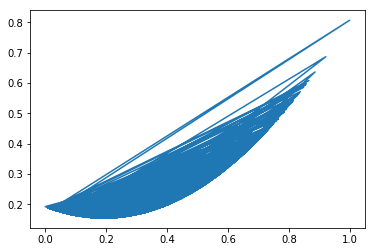

In [418]:
# plot impact of brier score with balanced datasets
# https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
from sklearn.metrics import brier_score_loss
from matplotlib import pyplot
from numpy import array
# define an imbalanced dataset
testy = y_test
# brier score for predicting different fixed probability values
predictions = y_pred_proba[:,1]
losses = [brier_score_loss(testy, [y for x in range(len(testy))]) for y in predictions]
# plot predictions vs loss
pyplot.plot(predictions, losses)
pyplot.show()

In [429]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score

# helper functions
def train_clf(clf, X_train, y_train):
    
    return clf.fit(X_train, y_train)
    
def pred_clf(clf, features, target):
    
    y_pred = clf.predict(features)
    y_pred_proba = clf.predict_proba(features)
    return brier_score_loss(target, y_pred_proba[:,1])

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    train_clf(clf, X_train, y_train)
    
    print("Brier score for training set is: {:.4f}".format(pred_clf(clf, X_train, y_train)))
    print("Brier score for testing set is: {:.4f}\n".format(pred_clf(clf, X_test, y_test)))

In [438]:
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=18)
log = LogisticRegression()
dtc = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
abc = AdaBoostClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)

algorithms = [nb,knn, log, dtc, rfc, abc, gbc]

for clf in algorithms:
    """
    print("\n{}: \n".format(clf.__class__.__name__))
    
    # create training data from first 100, then 200, then 300
    #for n in [179, 358, 537]:
        #train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
    """        
    print("{}:".format(clf))
    train_predict(clf, X_train, y_train, X_test, y_test)

GaussianNB(priors=None):
Brier score for training set is: 0.1644
Brier score for testing set is: 0.1867

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform'):
Brier score for training set is: 0.1335
Brier score for testing set is: 0.1512

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
Brier score for training set is: 0.1165
Brier score for testing set is: 0.1252

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, r

In [437]:
# OPTIMIZING KNN
# split training set into training and testing set
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, test_size = 0.3, random_state=100)
for n in range(5,20):    
    knn = KNeighborsClassifier(n_neighbors=n)
    print("Number of neighbors is: {}".format(n))
    train_predict(knn, X_train_cv, y_train_cv, X_test_cv, y_test_cv)

Number of neighbors is: 5
Brier score for training set is: 0.1150
Brier score for testing set is: 0.1576

Number of neighbors is: 6
Brier score for training set is: 0.1207
Brier score for testing set is: 0.1534

Number of neighbors is: 7
Brier score for training set is: 0.1241
Brier score for testing set is: 0.1481

Number of neighbors is: 8
Brier score for training set is: 0.1271
Brier score for testing set is: 0.1451

Number of neighbors is: 9
Brier score for training set is: 0.1295
Brier score for testing set is: 0.1447

Number of neighbors is: 10
Brier score for training set is: 0.1313
Brier score for testing set is: 0.1441

Number of neighbors is: 11
Brier score for training set is: 0.1331
Brier score for testing set is: 0.1433

Number of neighbors is: 12
Brier score for training set is: 0.1344
Brier score for testing set is: 0.1417

Number of neighbors is: 13
Brier score for training set is: 0.1351
Brier score for testing set is: 0.1408

Number of neighbors is: 14
Brier score for

In [439]:
gb_clf = GradientBoostingClassifier(random_state = 1)
param_grid = {
'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2,0.6,1.2], 'max_depth' : [1, 5, 9]
}

In [445]:
from sklearn.model_selection import GridSearchCV
gb_Grid = RandomizedSearchCV(gb_clf, param_grid, cv = 5, scoring = 'roc_auc', refit = True, n_jobs=-1, verbose = 2)

In [446]:
gb_Grid.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] learning_rate=0.2, max_depth=1, n_estimators=100 ................
[CV] learning_rate=0.2, max_depth=1, n_estimators=100 ................
[CV] learning_rate=0.2, max_depth=1, n_estimators=100 ................
[CV] learning_rate=0.2, max_depth=1, n_estimators=100 ................
[CV] . learning_rate=0.2, max_depth=1, n_estimators=100, total=  40.4s
[CV] learning_rate=0.2, max_depth=1, n_estimators=100 ................
[CV] . learning_rate=0.2, max_depth=1, n_estimators=100, total=  40.5s
[CV] learning_rate=0.2, max_depth=1, n_estimators=200 ................
[CV] . learning_rate=0.2, max_depth=1, n_estimators=100, total=  40.8s
[CV] learning_rate=0.2, max_depth=1, n_estimators=200 ................
[CV] . learning_rate=0.2, max_depth=1, n_estimators=100, total=  40.8s
[CV] learning_rate=0.2, max_depth=1, n_estimators=200 ................
[CV] . learning_rate=0.2, max_depth=1, n_estimators=100, total=  52.4s
[CV] learning_r

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.9min


[CV] . learning_rate=0.2, max_depth=5, n_estimators=300, total=11.8min
[CV] learning_rate=0.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.2, max_depth=5, n_estimators=300, total=11.8min
[CV] learning_rate=0.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.2, max_depth=5, n_estimators=400, total=15.6min
[CV] learning_rate=0.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.2, max_depth=5, n_estimators=400, total=15.7min
[CV] learning_rate=0.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=0.2, max_depth=5, n_estimators=400, total=15.4min
[CV] learning_rate=0.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=0.2, max_depth=9, n_estimators=100, total= 6.8min
[CV] learning_rate=0.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=0.2, max_depth=5, n_estimators=400, total=14.6min
[CV] learning_rate=0.2, max_depth=9, n_estimators=100 ................
[CV] .

[CV] . learning_rate=0.6, max_depth=5, n_estimators=300, total=20.5min
[CV] learning_rate=0.6, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=300, total=21.1min
[CV] learning_rate=0.6, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=300, total=22.1min
[CV] learning_rate=0.6, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=300, total=23.9min
[CV] learning_rate=0.6, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=400, total=31.5min
[CV] learning_rate=0.6, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=400, total=30.4min
[CV] learning_rate=0.6, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=0.6, max_depth=5, n_estimators=400, total=26.6min
[CV] learning_rate=0.6, max_depth=9, n_estimators=100 ................
[CV] .

[CV] . learning_rate=1.2, max_depth=5, n_estimators=200, total= 6.2min
[CV] learning_rate=1.2, max_depth=5, n_estimators=300 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=300, total= 9.3min
[CV] learning_rate=1.2, max_depth=5, n_estimators=300 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=300, total= 9.2min
[CV] learning_rate=1.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=300, total= 9.3min
[CV] learning_rate=1.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=300, total= 9.7min
[CV] learning_rate=1.2, max_depth=5, n_estimators=400 ................


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 342.9min


[CV] . learning_rate=1.2, max_depth=5, n_estimators=300, total=10.8min
[CV] learning_rate=1.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=400, total=15.0min
[CV] learning_rate=1.2, max_depth=5, n_estimators=400 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=400, total=15.6min
[CV] learning_rate=1.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=400, total=16.0min
[CV] learning_rate=1.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=1.2, max_depth=9, n_estimators=100, total= 7.4min
[CV] learning_rate=1.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=1.2, max_depth=5, n_estimators=400, total=15.8min
[CV] learning_rate=1.2, max_depth=9, n_estimators=100 ................
[CV] . learning_rate=1.2, max_depth=9, n_estimators=100, total= 7.5min
[CV] learning_rate=1.2, max_depth=9, n_estimators=100 ................
[CV] .

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 438.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.6, 1.2], 'max_depth': [1, 5, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [447]:
gb_Grid.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 300}

In [448]:
gb_Grid.best_estimator_
"""GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)"""

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [451]:
gb_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [452]:
train_predict(gb_clf, X_train, y_train, X_test, y_test)

Brier score for training set is: 0.1067
Brier score for testing set is: 0.1235



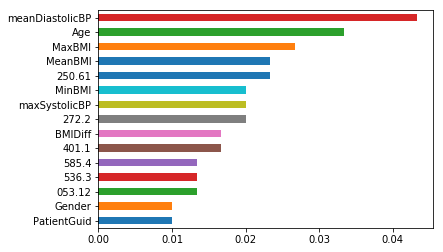

In [459]:
feature_importances = pd.Series(gb_clf.feature_importances_, index=X_train.columns) 
feature_importances.nlargest(15).sort_values(ascending = True).plot(kind='barh')